# Deep Convolutional GAN (DCGAN) with cats images

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

zsh:1: command not found: nvidia-smi


In [2]:
# !pip install TensorFlow==1.14
#!pip install -U TensorFlow

In [3]:
# from google.colab import drive 
# drive.mount('/content/drive')

In [4]:
#ファイル数のチェック
!ls "/Users/murakamikei/Desktop/GanPractice/npyPractice/data/cats" | wc -w  

     501


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array, array_to_img
#モデルの可視化
#from tensorflow.python.keras.utils.vis_utils import plot_model

from keras.utils.vis_utils import plot_model
from keras.models import load_model	
import glob

Using TensorFlow backend.
/Users/murakamikei/opt/anaconda3/envs/BudoPrac/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/murakamikei/opt/anaconda3/envs/BudoPrac/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/murakamikei/opt/anaconda3/envs/BudoPrac/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [6]:
img_rows = 64
img_cols = 64
channels = 3

# 入力画像の形状（64 x 64 x 3) //カラー画像
img_shape = (img_rows, img_cols, channels)

# noiseベクトルサイズ（生成器へのINPUT)
z_dim = 100

## Generator

In [7]:
def build_generator(z_dim):

    model = Sequential()

    #  全結合層によってnoiseベクトル(200次元）をReshapeして7x7x256 tensorに変換する
    model.add(Dense(256 * 8 * 8, input_dim=z_dim))
    model.add(Reshape((8, 8, 256)))

    # 転置畳み込みにより8x8x256 から 16x16x128テンソルに変換
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # 転置畳み込みにより16x16x128 から 32x32x64テンソルに変換
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # 転置畳み込みにより32x32x64 から32x32x32 テンソルに変換
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 32x32x32 to 64x64x3 tensor
    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same'))

    # tanh活性化を適用して出力（最終層だけはバッチ正規化はしない）
    model.add(Activation('tanh'))

    return model

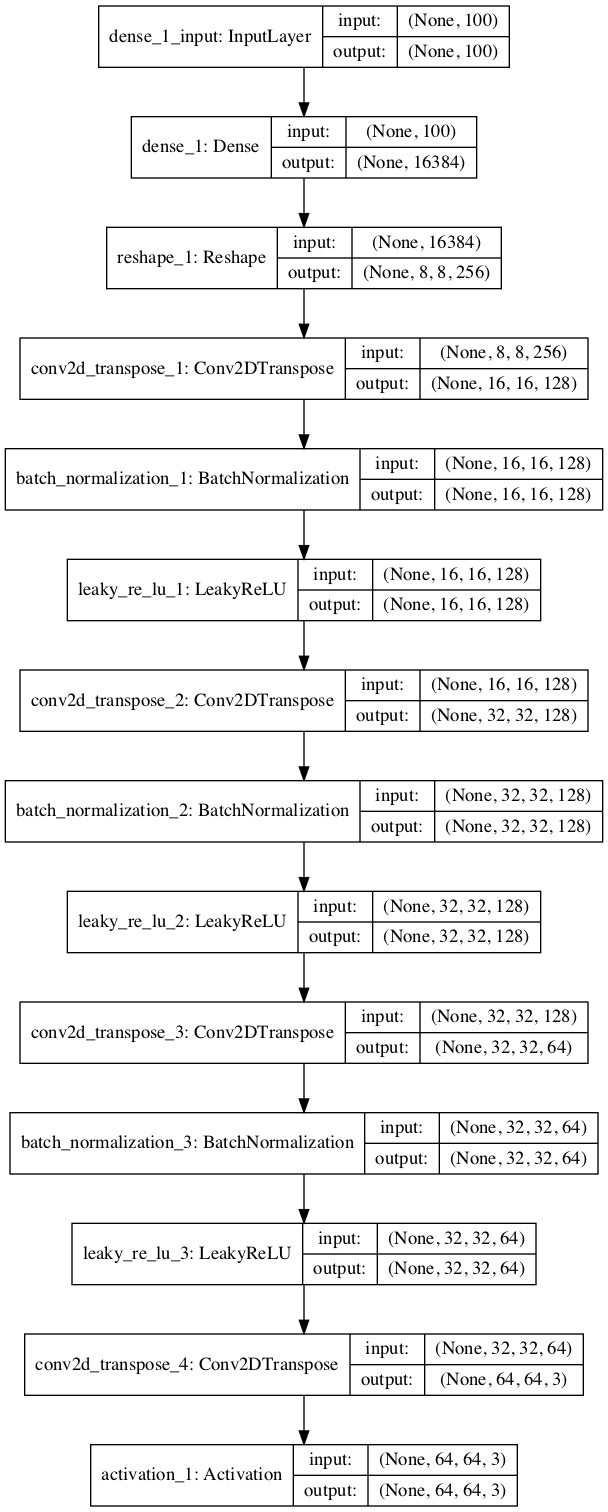

In [8]:
build_model = build_generator(z_dim)

plot_model(build_model, to_file="DCGAB_build_model.png", show_shapes=True)

## Discriminator

In [9]:
def build_discriminator(img_shape):

    model = Sequential()

    # 64x64x3(入力画像) を32x32x32のテンソルにする畳み込み層
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same')) #padding=sameにすると、入力の大きさをstridesの大きさで単純に割ったもの(28/2=14)が出力の大きさになる

    # Leaky ReLUによる活性化(最初の層にはバッチ正規化は適用しない)
    model.add(LeakyReLU(alpha=0.01))

    # 32x32x32 を16x16x64のテンソルにする畳み込み層
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLUによる活性化
    model.add(LeakyReLU(alpha=0.01))

    # 16x16x64 を8x8x128のテンソルにする畳み込み層
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # シグモイド関数で出力（０～１）
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

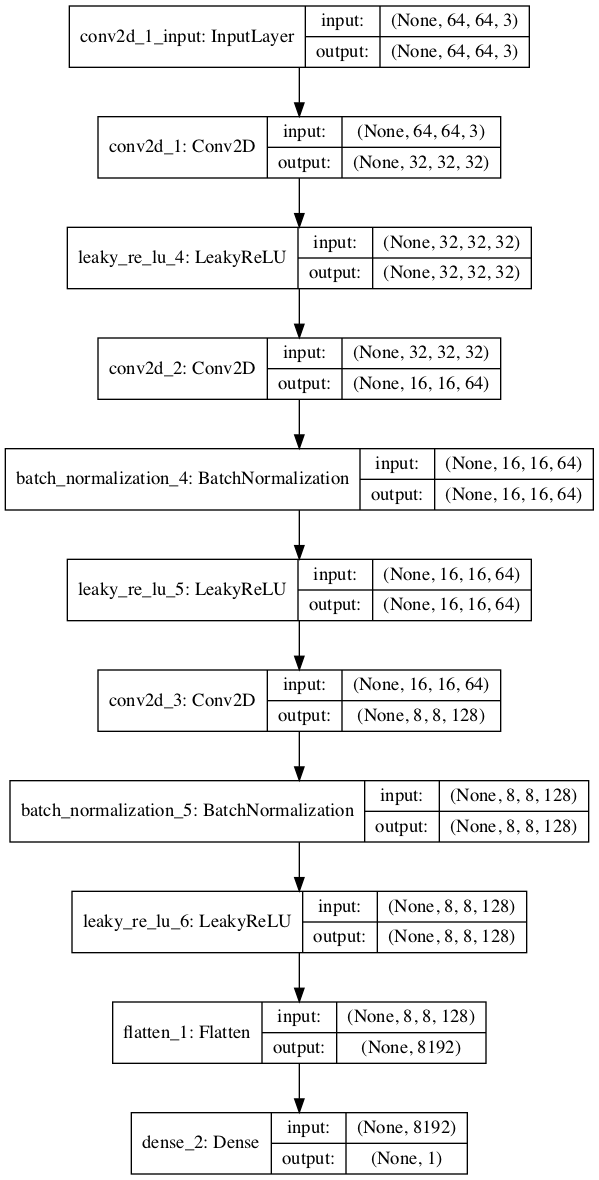

In [10]:
discriminator_model = build_discriminator(img_shape)

plot_model(discriminator_model, to_file="DCGAB_discriminator_model.png", show_shapes=True)

In [11]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 生成器と識別機を結合
    model.add(generator)
    model.add(discriminator)

    return model

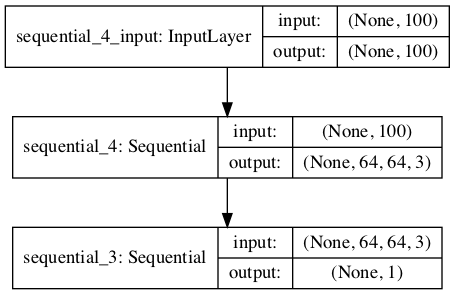

In [12]:
discriminator = build_discriminator(img_shape)
generator = build_generator(z_dim)
gan_model = build_gan(generator, discriminator)

plot_model(gan_model, to_file="DCGAB_gan_model.png", show_shapes=True)

In [13]:
# 識別機の生成とコンパイル
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

#前回学習の重みをロード
discriminator.load_weights('/content/drive/My Drive/Colab Notebooks/GAN/models/D/d_param-50490.hdf5')


# 生成器の生成
generator = build_generator(z_dim)

# 生成器の訓練時は識別機のパラメータを固定する
discriminator.trainable = False

# 識別機は固定のまま生成器を訓練するGANモデルの生成とコンパイル
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


OSError: Unable to open file (unable to open file: name = '/content/drive/My Drive/Colab Notebooks/GAN/models/D/d_param-50490.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [0]:
#途中までの学習済みモデルのロード
from keras.models import load_model

model_g_dir = "/content/drive/My Drive/Colab Notebooks/GAN/models/G"
model_d_dir = "/content/drive/My Drive/Colab Notebooks/GAN/models/D"

#generator = load_model('/content/drive/My Drive/Colab Notebooks/GAN/models/G/g_model-2499.h5')
generator.load_weights('/content/drive/My Drive/Colab Notebooks/GAN/models/G/g_param-50490.hdf5')


#gan = load_model('/content/drive/My Drive/Colab Notebooks/GAN/models/D/d_model-2499.h5')	
gan.load_weights('/content/drive/My Drive/Colab Notebooks/GAN/models/G/gan_param-50490.hdf5')


## Training

In [0]:
losses = []
accuracies = []
iteration_checkpoints = []
train_dir = "/content/drive/My Drive/Colab Notebooks/GAN/data/cats"
output_dir = "/content/drive/My Drive/Colab Notebooks/GAN/data/result"
model_g_dir = "/content/drive/My Drive/Colab Notebooks/GAN/models/G"
model_d_dir = "/content/drive/My Drive/Colab Notebooks/GAN/models/D"
height = 64
width = 64
num_of_trials = 50490


def train(iterations, batch_size, sample_interval, files):
  arrlist = []
  for i, imgfile in enumerate(files):
    img = load_img(imgfile, target_size=(height, width))    # 画像ファイルの読み込み
    array = img_to_array(img)    # 画像ファイルのnumpy化
    arrlist.append(array)    # numpy型データをリストに追加
    print("ファイルINDEX＝", i)
  # ndary型に変換
  X_train = np.array(arrlist)   # (2000, 64, 64, 3)

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
    

  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))
  print("check-001")

  for iteration in range(iterations):

      # -------------------------
      #  Train the Discriminator
      # -------------------------
      print("iteration=", iteration)

      # Get a random batch of real images
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
       # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, 100))
      gen_imgs = generator.predict(z)
       # Train Discriminator
 

      d_loss_real = discriminator.train_on_batch(imgs, real)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
      d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
     
      
      # ---------------------
      #  Train the Generator
      # ---------------------

      # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, 100))
      gen_imgs = generator.predict(z)

      # Train Generator
      g_loss = gan.train_on_batch(z, real)

      if (iteration + 1) % sample_interval == 0:

          # Save losses and accuracies so they can be plotted after training
          losses.append((d_loss, g_loss))
          accuracies.append(100.0 * accuracy)
          iteration_checkpoints.append(iteration + 1)

          # Output training progress
          print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

          # Output a sample of generated image
          sample_images(generator, iteration)
          #識別器のモデル保存
          d_model_file=os.path.join(model_d_dir, "d_model-" + str(iteration + num_of_trials) +  ".h5")
          d_param_file=os.path.join(model_d_dir, "d_param-" + str(iteration + num_of_trials) +  ".hdf5")
          discriminator.save(d_model_file)	
          discriminator.save_weights(d_param_file)
          
          #生成器のモデル保存
          g_model_file=os.path.join(model_g_dir, "g_model-" + str(iteration + num_of_trials) +  ".h5")
          g_param_file=os.path.join(model_g_dir, "g_param-" + str(iteration + num_of_trials) +  ".hdf5")
          generator.save(g_model_file)	
          generator.save_weights(g_param_file)
          gan_model_file=os.path.join(model_g_dir, "gan_model-" + str(iteration + num_of_trials) +  ".h5")
          gan_param_file=os.path.join(model_g_dir, "gan_param-" + str(iteration + num_of_trials) +  ".hdf5")

          gan.save(gan_model_file)	
          gan.save_weights(gan_param_file)
          
          



In [0]:
def sample_images(generator, iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)  # (16, 64, 64, 3)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    #print("gen_imgs_shape=", gen_imgs.shape)
    #print("gen_imgs_type=", type(gen_imgs.shape))
    #print("gen_imgs_shape2=", gen_imgs[0,:,:,:].shape)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            #print("shape=",gen_imgs[cnt, :, :, :].shape)
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    #file保存
    output_file = os.path.join(output_dir, 'result_' + str(iteration + num_of_trials) +'.png')
    plt.savefig(output_file)


In [0]:
files = glob.glob("/content/drive/My Drive/Colab Notebooks/GAN/data/cats/*.jpg")
# Set hyperparameters
iterations = 5000
batch_size =64
sample_interval = 500

# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval, files[0:500])

ファイルINDEX＝ 0
ファイルINDEX＝ 1
ファイルINDEX＝ 2
ファイルINDEX＝ 3
ファイルINDEX＝ 4
ファイルINDEX＝ 5
ファイルINDEX＝ 6
ファイルINDEX＝ 7
ファイルINDEX＝ 8
ファイルINDEX＝ 9
ファイルINDEX＝ 10
ファイルINDEX＝ 11
ファイルINDEX＝ 12
ファイルINDEX＝ 13
ファイルINDEX＝ 14
ファイルINDEX＝ 15
ファイルINDEX＝ 16
ファイルINDEX＝ 17
ファイルINDEX＝ 18
ファイルINDEX＝ 19
ファイルINDEX＝ 20
ファイルINDEX＝ 21
ファイルINDEX＝ 22
ファイルINDEX＝ 23
ファイルINDEX＝ 24
ファイルINDEX＝ 25
ファイルINDEX＝ 26
ファイルINDEX＝ 27
ファイルINDEX＝ 28
ファイルINDEX＝ 29
ファイルINDEX＝ 30
ファイルINDEX＝ 31
ファイルINDEX＝ 32
ファイルINDEX＝ 33
ファイルINDEX＝ 34
ファイルINDEX＝ 35
ファイルINDEX＝ 36
ファイルINDEX＝ 37
ファイルINDEX＝ 38
ファイルINDEX＝ 39
ファイルINDEX＝ 40
ファイルINDEX＝ 41
ファイルINDEX＝ 42
ファイルINDEX＝ 43
ファイルINDEX＝ 44
ファイルINDEX＝ 45
ファイルINDEX＝ 46
ファイルINDEX＝ 47
ファイルINDEX＝ 48
ファイルINDEX＝ 49
ファイルINDEX＝ 50
ファイルINDEX＝ 51
ファイルINDEX＝ 52
ファイルINDEX＝ 53
ファイルINDEX＝ 54
ファイルINDEX＝ 55
ファイルINDEX＝ 56
ファイルINDEX＝ 57
ファイルINDEX＝ 58
ファイルINDEX＝ 59
ファイルINDEX＝ 60
ファイルINDEX＝ 61
ファイルINDEX＝ 62
ファイルINDEX＝ 63
ファイルINDEX＝ 64
ファイルINDEX＝ 65
ファイルINDEX＝ 66
ファイルINDEX＝ 67
ファイルINDEX＝ 68
ファイルINDEX＝ 69
ファイルINDEX＝ 70
ファイルINDEX＝ 71
ファ

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


iteration= 1


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


iteration= 2
iteration= 3
iteration= 4
iteration= 5
iteration= 6
iteration= 7
iteration= 8
iteration= 9
iteration= 10
iteration= 11
iteration= 12
iteration= 13
iteration= 14
iteration= 15
iteration= 16
iteration= 17
iteration= 18
iteration= 19
iteration= 20
iteration= 21
iteration= 22
iteration= 23
iteration= 24
iteration= 25
iteration= 26
iteration= 27
iteration= 28
iteration= 29
iteration= 30
iteration= 31
iteration= 32
iteration= 33
iteration= 34
iteration= 35
iteration= 36
iteration= 37
iteration= 38
iteration= 39
iteration= 40
iteration= 41
iteration= 42
iteration= 43
iteration= 44
iteration= 45
iteration= 46
iteration= 47
iteration= 48
iteration= 49
iteration= 50
iteration= 51
iteration= 52
iteration= 53
iteration= 54
iteration= 55
iteration= 56
iteration= 57
iteration= 58
iteration= 59
iteration= 60
iteration= 61
iteration= 62
iteration= 63
iteration= 64
iteration= 65
iteration= 66
iteration= 67
iteration= 68
iteration= 69
iteration= 70
iteration= 71
iteration= 72
iteration= 73


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration= 1500
iteration= 1501
iteration= 1502
iteration= 1503
iteration= 1504
iteration= 1505
iteration= 1506
iteration= 1507
iteration= 1508
iteration= 1509
iteration= 1510
iteration= 1511
iteration= 1512
iteration= 1513
iteration= 1514
iteration= 1515
iteration= 1516
iteration= 1517
iteration= 1518
iteration= 1519
iteration= 1520
iteration= 1521
iteration= 1522
iteration= 1523
iteration= 1524
iteration= 1525
iteration= 1526
iteration= 1527
iteration= 1528
iteration= 1529
iteration= 1530
iteration= 1531
iteration= 1532
iteration= 1533
iteration= 1534
iteration= 1535
iteration= 1536
iteration= 1537
iteration= 1538
iteration= 1539
iteration= 1540
iteration= 1541
iteration= 1542
iteration= 1543
iteration= 1544
iteration= 1545
iteration= 1546
iteration= 1547
iteration= 1548
iteration= 1549
iteration= 1550
iteration= 1551
iteration= 1552
iteration= 1553
iteration= 1554
iteration= 1555
iteration= 1556
iteration= 1557
iteration= 1558
iteration= 1559
iteration= 1560
iteration= 1561
iteratio